In [1]:
seed=1
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['PYTHONHASHSEED']=str(seed)
import numpy as np
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense ,Input,concatenate ,Conv2D,Conv2DTranspose,\
MaxPooling2D,AveragePooling2D, LSTM ,Reshape, TimeDistributed,ReLU, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adagrad
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import warnings
import glob
import math
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from collections import deque
from tqdm import tqdm,trange
import gym
from copy import copy , deepcopy
#tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [2]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2


import tensorflow
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import  ReLU#,TanH
TanH=tensorflow.keras.layers.Activation('tanh')
Sigmoid=tensorflow.keras.layers.Activation('sigmoid')

n_act=4
n_state=24

class Actor(Model):
  def __init__(self,n_act):
    super(Actor, self).__init__()
    self.d1 = Dense(512, activation='relu')
    self.d2 = Dense(256, activation='relu')
    self.mean = Dense(n_act)
    self.tanh  = TanH
    self.sigmoid  = Sigmoid
    self.std = Dense(n_act)

  def call(self, x):
    
    x = self.d1(x)
    x = self.d2(x)
    #x = self.d3(x)
    #x = self.d4(x)
    mean = self.mean(x)
    mean = self.tanh(mean)
    std = self.std(x)
    std = self.sigmoid(std)
    return mean,std+10e-10


class Critic(Model):
  def __init__(self):
    super(Critic, self).__init__()
    self.d1 = Dense(512, activation='relu')
    self.d2 = Dense(256, activation='relu')
    #self.d3 = Dense(5, activation='relu')
    #self.d4 = Dense(6, activation='relu')
    self.value = Dense(1)
    

  def call(self, x):
    
    x = self.d1(x)
    x = self.d2(x)
    #x = self.d3(x)
    #x = self.d4(x)
    value = self.value(x)
    return value

class ppo_model():
    def __init__(self):
        self._actor=Actor(4)
        self._critic=Critic()
        self._debug = False
        self._actor_opt= Adam(0.001)
        self._critic_opt= Adam(0.001)
        self.value_coef=0.5
        self.entropy_coef=0.01
        self._gamma=0.99
        self._lambda=0.95
        self.clip_epsilon=0.05
        self._advantage=10
        
    def get_advantages(self,values, masks, rewards):
        target_qvals = []
        for i in range(len(rewards)-self._advantage):
            _values=values[i:i+self._advantage+1]
            _rewards=rewards[i:i+self._advantage]
            _masks=masks[i:i+self._advantage]
            #gae = 0
            #for j in reversed(range(self._advantage)):
            #    delta = _rewards[j] + self._gamma * _values[j + 1] * _masks[j] - _values[j]
            #    gae = delta + self._gamma * self._lambda * _masks[j] * gae
            gae=0
            for j in range(self._advantage):
                delta = _rewards[j] + self._gamma * _values[j + 1] * _masks[j] - _values[j]
                gae +=  ((self._gamma * self._lambda)**j) * _masks[j] * delta
            target_qvals.append(gae + _values[0])

        adv = np.array(target_qvals) - values[:-self._advantage-1]
        return target_qvals, (adv - np.mean(adv)) / (np.std(adv) + 1e-10)
    
    def _get_advantages(self,values, masks, rewards):
        target_qvals = []
        gae=0
        for i in reversed(range(len(rewards))):
                delta = rewards[j] + self.gamma * values[j + 1] * masks[j] - values[j]
                gae = delta + self._gamma * self._lambda * masks[j] * gae
        target_qvals.append(gae + _values[0])

        adv = np.array(target_qvals) - values[:-self._advantage-1]
        return target_qvals, (adv - np.mean(adv)) / (np.std(adv) + 1e-10)

    def actor_loss(self,mean,std,old_mean,old_std,old_action,advantage_raw):#, rewards, values):
            old_probs = self.get_log_probs(old_action,old_mean,old_std)
            new_probs = self.get_log_probs(old_action,mean,std)
            entropy_loss = self.get_entropy(std)
            ratio = K.exp(new_probs-old_probs)
            p1 = ratio * advantage_raw
            p2 = K.clip(ratio, min_value=1 - self.clip_epsilon, max_value=1 + self.clip_epsilon) * advantage_raw
            actor_loss = K.mean(K.minimum(p1, p2))
            #critic_loss = 0#K.mean(K.square(rewards - values))
            total_loss =   -actor_loss - self.entropy_coef * entropy_loss #* K.mean(-(new_probs * K.log(new_probs + 1e-10)))
            #tf.print('A',tf.reduce_sum(new_probs),tf.reduce_sum(old_probs),'B',tf.reduce_sum(ratio))
            return total_loss

    @tf.function
    def train_actor(self,curr_states,_old_mean,_old_std,_old_actions,_advantage_raw):
             _advantage_raw=tf.cast(_advantage_raw,tf.float32)
             with tf.GradientTape() as tape:
                  mean,std = self._actor(curr_states, training=True)
                  if self._debug ==True :tf.print('1 : train_actor :',tf.reduce_sum(curr_states),tf.reduce_sum(mean),tf.reduce_sum(std))
                  _act_loss = self.actor_loss(mean,std,_old_mean,_old_std,_old_actions,_advantage_raw)
                  gradients = tape.gradient(_act_loss, self._actor.trainable_variables)
                  self._actor_opt.apply_gradients(zip(gradients, self._actor.trainable_variables))
                  #tf.print('actor grad : ',gradients[0])
             return  _act_loss

    @tf.function          
    def critic_loss(self,_values,_target_rewards):
            batch_size=_values.shape[0]
            critic_loss=self.value_coef*2*tf.reduce_sum(tf.square(_target_rewards-_values))/batch_size
            return critic_loss
        
    @tf.function
    def train_critic(self,_states,_target_rewards):
            with tf.GradientTape() as tape:
                _values=self._critic(_states)
                _values=tf.cast(_values,tf.float32)
                _target_rewards=tf.cast(_target_rewards,tf.float32)
                _critic_loss=self.critic_loss(_values,_target_rewards)
                gradients = tape.gradient(_critic_loss, self._critic.trainable_variables)
                self._critic_opt.apply_gradients(zip(gradients, self._critic.trainable_variables))
                #tf.print('critic grad : ',gradients[0])
            return _critic_loss
    @tf.function
    def get_log_probs(self,_actions,mean,std):
        _actions=tf.cast(_actions,tf.float32)
        mean=tf.cast(mean,tf.float32)
        std=tf.cast(std,tf.float32)
        _var = -0.5*((_actions-mean)/(std))**2
        _coef = 1/(std*tf.sqrt(2*np.pi)) 
        
        _probs = _coef*tf.cast(tf.exp(_var),tf.float32)
        #_probs = tf.abs(_probs+ )
        log_probs = tf.math.log(_probs)
        #if _debug==True:
        #    tf.print('2 : log_prob : _var  ',tf.reduce_sum(_var),tf.reduce_sum(_coef),tf.reduce_sum(_actions))
        #    tf.print('2 : log_prob : _probs',tf.reduce_sum(_probs),tf.reduce_sum(log_probs))
        return log_probs
    def get_entropy(self,std):
        entropy = 0.5 * (tf.math.log(2 * np.pi * std ** 2) + 1)
        return entropy


def get_model_actor_simple(input_dims, output_dims):
    state_input = Input(shape=input_dims)
    old_actions = Input(shape=(1, output_dims,))
    old_probs = Input(shape=(1, output_dims,))
    advantages = Input(shape=(1, 1,))
    rewards = Input(shape=(1, 1,))
    values = Input(shape=(1, 1,))

    # Classification block
    x = Dense(512, activation='relu', name='fc1')(state_input)
    x = Dense(256, activation='relu', name='fc2')(x)
    mean = Dense(n_actions, activation='tanh', name='mean')(x)
    std = Dense(n_actions, activation='sigmoid', name='std')(x)

    model = Model(inputs=[state_input, old_actions, old_probs, advantages, rewards, values],
                  outputs=[mean,std])
    model.compile(optimizer=Adam(lr=1e-4), loss=[ppo_loss(
        old_actions=old_actions,
        old_probs=old_probs,
        advantages=advantages,
        rewards=rewards,
        values=values)])
    # model.summary()
    return model





def get_model_critic_simple(input_dims):
    state_input = Input(shape=input_dims)

    # Classification block
    x = Dense(512, activation='relu', name='fc1')(state_input)
    x = Dense(256, activation='relu', name='fc2')(x)
    out_actions = Dense(1, activation='tanh')(x)

    model = Model(inputs=[state_input], outputs=[out_actions])
    model.compile(optimizer=Adam(lr=1e-4), loss='mse')
    # model.summary()
    return model


def test_reward():
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state_input = K.expand_dims(state, 0)
        mean,std = _model._actor(state_input)
        act=np.random.normal(mean,std)[0]
        next_state, reward, done, _ = env.step(mean[0])
        if reward == -100:
            reward=-2
        state = next_state
        total_reward += reward
        
    return total_reward
    
image_based = False

env=gym.make('BipedalWalker-v2')
env.seed(seed)
state = env.reset()
state_dims = env.observation_space.shape
n_actions = env.action_space.shape[0]

#tensor_board = TensorBoard(log_dir='./logs')


#model_actor = get_model_actor_simple(input_dims=state_dims, output_dims=n_actions)
#model_critic = get_model_critic_simple(input_dims=state_dims)
_model=ppo_model()
ppo_steps = 2000
target_reached = False
best_reward = 0
iters = 0
episodes = 1000
adv=_model._advantage
rewards_log=[]
max_reward=0
for episode in range(episodes):

    curr_states = []
    old_actions = []
    old_probs =[]
    values = []
    masks = []
    rewards = []
    old_means = []
    old_stds  = []
    state_input = None
    sum_reward=0
    sum_reward_log=0
    for itr in trange(ppo_steps+adv):
        state_input = K.expand_dims(state, 0)
        mean,std = _model._actor(state_input)
        q_value  = _model._critic(state_input)
        action = np.random.normal(mean,std)[0]
        #prob=get_log_probs(action,mean,std)
        observation, reward, done, info = env.step(action)
        if reward == -100:
            reward=-2
        #print('itr: ' + str(itr) + ', action=' + str(action) + ', reward=' + str(reward) + ', q val=' + str(q_value.numpy()))
        mask = not done

        curr_states.append(state)
        old_actions.append(action)
        #old_probs.append(prob)
        old_means.append(mean)
        old_stds.append(std)
        values.append(q_value)
        masks.append(mask)
        rewards.append(reward)
        sum_reward+=reward

        state = observation
        if done:
            sum_reward_log=copy(sum_reward)
            sum_reward=0
            env.reset()
        
    state_input=K.expand_dims(state, 0)
    q_value = _model._critic(state_input)
    values.append(q_value)
    _curr_states=np.array(curr_states).reshape(-1,24)
    _old_actions=np.array(old_actions).reshape(-1,4)
    _old_means=np.array(old_means).reshape(-1,4)
    _old_stds=np.array(old_stds).reshape(-1,4)
    _values=np.array(values).reshape(-1,1)
    _rewards=np.array(rewards).reshape(-1,1)
    _masks  = np.array(masks).reshape(-1,1)
    
    for _ in range(5):
        #for batch in batches:
            _target_qvals, _advantages = _model.get_advantages(_values, _masks, _rewards)
            _model.train_actor(_curr_states[:-adv],_old_means[:-adv],_old_stds[:-adv],_old_actions[:-adv],_advantages)
            _model.train_critic(_curr_states[:-adv],_target_qvals)                            

    avg_reward = np.mean([test_reward() for _ in range(5)])
    print('episode :',episode,'reward :',sum_reward_log)   
    print('total test reward=' + str(avg_reward))
    if avg_reward >=max_reward:
        _model._actor.save_weights('ppo_best_actor.hdf5')
        _model._critic.save_weights('ppo_best_critic'+'.hdf5')
        best_eps=episode
        max_reward = avg_reward
    rewards_log.append([sum_reward_log,avg_reward])
    iters += 1
    env.reset()

env.close()
plt.plot(rewards_log)

  0%|                                                                                         | 0/2010 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



  2%|█▉                                                                             | 48/2010 [00:00<00:04, 476.47it/s]

episode : 0 reward : 1.4594871474785598
total test reward=-29.056191782637626


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.48it/s]

episode : 1 reward : -0.6771861768513214
total test reward=-0.6097708539431418


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.15it/s]

episode : 2 reward : -3.902992971148543
total test reward=-22.160211313084066


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.87it/s]

episode : 3 reward : -0.026712546481590493
total test reward=-22.16071957792286


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.94it/s]

episode : 4 reward : -23.836526785376822
total test reward=-21.837257020546993


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.30it/s]

episode : 5 reward : -0.3078190520169042
total test reward=-23.39882572991684


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.93it/s]

episode : 6 reward : 1.0922837956852427
total test reward=4.96466173134842


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.79it/s]

episode : 7 reward : -2.891393559871063
total test reward=4.398082201714795


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.86it/s]

episode : 8 reward : -0.36767958445403615
total test reward=4.914907563027709


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 547.32it/s]

episode : 9 reward : -1.4962715849403514
total test reward=-23.048763559300454


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.21it/s]

episode : 10 reward : 0.7666850073890621
total test reward=4.324847769948211


  6%|████▎                                                                         | 112/2010 [00:00<00:03, 554.16it/s]

episode : 11 reward : 0.40072383283748225
total test reward=-19.720030995012955


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 574.25it/s]

episode : 12 reward : -0.37492150795521195
total test reward=4.920033898723574


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.30it/s]

episode : 13 reward : -4.241408295143781
total test reward=4.942566729572039


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 559.77it/s]

episode : 14 reward : -5.253588396300401
total test reward=4.359802083636788


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 553.29it/s]

episode : 15 reward : -3.4966559367792955
total test reward=4.714045586378903


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 593.81it/s]

episode : 16 reward : -0.651353951596241
total test reward=4.320599488458429


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 595.66it/s]

episode : 17 reward : -2.584388563499288
total test reward=4.239084333571645


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 589.81it/s]

episode : 18 reward : -3.339597549032238
total test reward=4.117894770417953


  2%|█▉                                                                             | 49/2010 [00:00<00:04, 481.52it/s]

episode : 19 reward : 0.15250520808053114
total test reward=4.1894002842712625


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.62it/s]

episode : 20 reward : 0.6994727213811349
total test reward=4.018652773046672


  5%|████▎                                                                         | 110/2010 [00:00<00:03, 549.80it/s]

episode : 21 reward : -1.4490799521625926
total test reward=0.11069387836035616


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.67it/s]

episode : 22 reward : -5.358979687502133
total test reward=0.4707268099053909


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 553.87it/s]

episode : 23 reward : -0.06961490862765807
total test reward=-11.657704801692203


  5%|████▏                                                                         | 109/2010 [00:00<00:03, 541.21it/s]

episode : 24 reward : -6.203186586519361
total test reward=-30.67543249363161


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.41it/s]

episode : 25 reward : -2.0632290466955885
total test reward=0.6379433711327932


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.57it/s]

episode : 26 reward : -3.206084173518404
total test reward=-24.25340511341548


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 556.13it/s]

episode : 27 reward : 1.0065827062617787
total test reward=-19.53523764297741


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.84it/s]

episode : 28 reward : -3.4218162985133143
total test reward=-20.462320153159673


  6%|████▍                                                                         | 114/2010 [00:00<00:03, 561.79it/s]

episode : 29 reward : -0.6258327170352724
total test reward=-16.33027768998512


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.94it/s]

episode : 30 reward : -0.8823861399626463
total test reward=-2.775796731519813


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.87it/s]

episode : 31 reward : -0.6929526799176724
total test reward=0.29048856776368026


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 568.66it/s]

episode : 32 reward : -1.458443098523512
total test reward=0.561209727477099


  3%|██                                                                             | 53/2010 [00:00<00:03, 526.33it/s]

episode : 33 reward : -22.988861403115934
total test reward=0.5146840958743943


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.69it/s]

episode : 34 reward : 1.4967732232949387
total test reward=0.5345870537459531


  6%|████▍                                                                         | 114/2010 [00:00<00:03, 565.87it/s]

episode : 35 reward : 1.6002656989402788
total test reward=0.32746768236958895


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.75it/s]

episode : 36 reward : -2.082617688793437
total test reward=0.440296136047792


  3%|██                                                                             | 51/2010 [00:00<00:03, 506.31it/s]

episode : 37 reward : -1.1525582971576291
total test reward=0.1795274459076432


  5%|████                                                                          | 106/2010 [00:00<00:03, 522.02it/s]

episode : 38 reward : -0.467973312989993
total test reward=0.40988162721110816


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.32it/s]

episode : 39 reward : -0.7603445292565256
total test reward=3.7239488077948457


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.27it/s]

episode : 40 reward : -1.2893111607472865
total test reward=4.076414587350953


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 585.95it/s]

episode : 41 reward : -1.7286110012740035
total test reward=1.7680767435759548


  6%|████▎                                                                         | 112/2010 [00:00<00:03, 558.98it/s]

episode : 42 reward : -0.6550213705825714
total test reward=0.7248450573409875


  2%|█▉                                                                             | 48/2010 [00:00<00:04, 476.52it/s]

episode : 43 reward : 0.046959577540313546
total test reward=3.9117813468024387


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.69it/s]

episode : 44 reward : -3.4634260411193685
total test reward=4.706448460204971


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.32it/s]

episode : 45 reward : 2.0362544036825057
total test reward=5.0266866495928735


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.04it/s]

episode : 46 reward : 1.3788502144820307
total test reward=5.939230088937755


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.95it/s]

episode : 47 reward : 0.21653780293007108
total test reward=5.1390182314108275


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 589.54it/s]

episode : 48 reward : 1.4997207898268314
total test reward=5.731581837894803


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.12it/s]

episode : 49 reward : -19.632260979679014
total test reward=5.281788391410983


  3%|██                                                                             | 52/2010 [00:00<00:03, 516.06it/s]

episode : 50 reward : 0.7450881020439013
total test reward=4.389841641317646


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.49it/s]

episode : 51 reward : 1.1718129038647143
total test reward=3.3915125549256095


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.93it/s]

episode : 52 reward : 1.2278259389541946
total test reward=4.036243899670689


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.01it/s]

episode : 53 reward : 1.1931911900199168
total test reward=4.55891554757957


  3%|██                                                                             | 54/2010 [00:00<00:03, 530.83it/s]

episode : 54 reward : 0.2806356618325645
total test reward=5.197830377541628


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.61it/s]

episode : 55 reward : -0.8380172699590083
total test reward=4.747546155104997


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.32it/s]

episode : 56 reward : 1.9492658617842031
total test reward=5.040517976615993


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.14it/s]

episode : 57 reward : 2.5624772672913316
total test reward=4.935377797622585


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.60it/s]

episode : 58 reward : 1.1483093026790265
total test reward=4.222936053544984


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.11it/s]

episode : 59 reward : 2.629578826600013
total test reward=3.1106338323821072


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.32it/s]

episode : 60 reward : 2.1834689990143143
total test reward=3.5211099430725943


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 566.02it/s]

episode : 61 reward : 1.0421718675277294
total test reward=4.191165303341906


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.80it/s]

episode : 62 reward : 4.0749576187941825
total test reward=4.613782349138606


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.73it/s]

episode : 63 reward : -0.8020340955899923
total test reward=5.06967133523884


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.23it/s]

episode : 64 reward : 1.132856743979758
total test reward=5.678810217630606


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.15it/s]

episode : 65 reward : 3.277115016578813
total test reward=7.220492503930475


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.99it/s]

episode : 66 reward : -0.18220153115605298
total test reward=7.072863191353312


  3%|██                                                                             | 53/2010 [00:00<00:03, 526.03it/s]

episode : 67 reward : 2.213120206912702
total test reward=7.975732687946146


  3%|██                                                                             | 51/2010 [00:00<00:03, 506.27it/s]

episode : 68 reward : 0.009049556988668606
total test reward=7.741701094419244


  3%|██                                                                             | 51/2010 [00:00<00:03, 506.12it/s]

episode : 69 reward : 1.9204188313227633
total test reward=6.047163444978474


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.25it/s]

episode : 70 reward : 0.5992759097440712
total test reward=5.848059743452941


  3%|██                                                                             | 53/2010 [00:00<00:03, 521.19it/s]

episode : 71 reward : -0.2033903068556735
total test reward=5.1456185572329325


  2%|█▊                                                                             | 47/2010 [00:00<00:04, 457.52it/s]

episode : 72 reward : 1.537498138927265
total test reward=5.179449835194646


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.73it/s]

episode : 73 reward : 3.2023919178661693
total test reward=5.197665662363357


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 589.63it/s]

episode : 74 reward : 3.9136518720582982
total test reward=4.8953105006651025


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.80it/s]

episode : 75 reward : 4.390635967559404
total test reward=5.444514038929552


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.89it/s]

episode : 76 reward : -41.13608080895831
total test reward=5.50083331585589


  3%|██                                                                             | 52/2010 [00:00<00:03, 516.31it/s]

episode : 77 reward : -0.36642501082378165
total test reward=5.562516438516762


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 585.52it/s]

episode : 78 reward : 1.6726714677853316
total test reward=4.472924203591431


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.62it/s]

episode : 79 reward : -2.924718641158858
total test reward=5.494097165901198


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.79it/s]

episode : 80 reward : 1.0237006991891335
total test reward=5.388583176524248


  3%|██                                                                             | 54/2010 [00:00<00:03, 530.81it/s]

episode : 81 reward : 2.077813297135612
total test reward=5.747480233322117


  3%|██                                                                             | 54/2010 [00:00<00:03, 530.65it/s]

episode : 82 reward : 3.9735719069131914
total test reward=6.353814062007901


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 585.54it/s]

episode : 83 reward : 1.487883306629488
total test reward=7.702102879209565


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.73it/s]

episode : 84 reward : 0.9505245082753575
total test reward=7.796001118526542


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 580.19it/s]

episode : 85 reward : 3.3555812266990497
total test reward=8.969512130886534


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.87it/s]

episode : 86 reward : 5.811302189418225
total test reward=6.150290498430738


  6%|████▍                                                                         | 114/2010 [00:00<00:03, 567.96it/s]

episode : 87 reward : 1.2987755942757269
total test reward=5.924466332406462


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.79it/s]

episode : 88 reward : 2.042694811772771
total test reward=6.806394326513254


  5%|███▉                                                                          | 103/2010 [00:00<00:03, 521.50it/s]

episode : 89 reward : 6.215966736773074
total test reward=5.506200875692417


  3%|██                                                                             | 51/2010 [00:00<00:03, 506.14it/s]

episode : 90 reward : 3.2248237774543504
total test reward=5.850647844694758


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.75it/s]

episode : 91 reward : 1.8212472060160305
total test reward=6.291945420428636


  6%|████▍                                                                         | 115/2010 [00:00<00:03, 572.66it/s]

episode : 92 reward : 3.9440966955919228
total test reward=6.705148223538184


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.41it/s]

episode : 93 reward : 3.878014684128458
total test reward=6.156834931232225


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.61it/s]

episode : 94 reward : 6.900499284352184
total test reward=3.842605172892398


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.80it/s]

episode : 95 reward : 5.053756102795482
total test reward=4.626816397411251


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.62it/s]

episode : 96 reward : 5.088346374727601
total test reward=4.30320417341306


  3%|██                                                                             | 54/2010 [00:00<00:03, 530.66it/s]

episode : 97 reward : 5.482141232924359
total test reward=4.2145007672164265


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.60it/s]

episode : 98 reward : 6.517472319522941
total test reward=10.992911211099162


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.15it/s]

episode : 99 reward : 1.596303530651603
total test reward=10.539862006109228


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.83it/s]

episode : 100 reward : 5.600092393406696
total test reward=13.01253830562521


  3%|██                                                                             | 53/2010 [00:00<00:03, 526.16it/s]

episode : 101 reward : 3.055201063816134
total test reward=11.182264922346917


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.48it/s]

episode : 102 reward : 3.445886893440208
total test reward=15.146786534936684


  2%|█▊                                                                             | 47/2010 [00:00<00:04, 468.62it/s]

episode : 103 reward : 5.9012705673723
total test reward=15.817945328790222


  3%|██                                                                             | 53/2010 [00:00<00:03, 521.00it/s]

episode : 104 reward : 7.761973836446524
total test reward=14.499562588208594


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.49it/s]

episode : 105 reward : 3.8253010415159014
total test reward=13.346668797541753


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.30it/s]

episode : 106 reward : 6.833302263639862
total test reward=12.2287276287188


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.08it/s]

episode : 107 reward : 8.430017187456274
total test reward=10.785339666653757


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 589.79it/s]

episode : 108 reward : 4.7872117012226605
total test reward=10.091088465112824


  6%|████▍                                                                         | 113/2010 [00:00<00:03, 562.73it/s]

episode : 109 reward : 2.751253456396161
total test reward=10.501723347335748


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.48it/s]

episode : 110 reward : 4.408214313373248
total test reward=14.403467455281836


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.86it/s]

episode : 111 reward : 3.662832015896429
total test reward=14.665154770455127


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.58it/s]

episode : 112 reward : 3.4160061656098204
total test reward=14.043714680282989


  6%|████▍                                                                         | 114/2010 [00:00<00:03, 565.68it/s]

episode : 113 reward : 11.921138360256066
total test reward=13.776855074051587


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 530.26it/s]

episode : 114 reward : 14.950569868177539
total test reward=12.783483799511888


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.81it/s]

episode : 115 reward : 13.232981707261942
total test reward=14.09013419210803


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.70it/s]

episode : 116 reward : 8.611590543415042
total test reward=11.777480167287205


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.84it/s]

episode : 117 reward : 4.604473144253182
total test reward=13.962271478271578


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.61it/s]

episode : 118 reward : 8.222560427094562
total test reward=14.927173481817494


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.69it/s]

episode : 119 reward : 8.263952436713907
total test reward=12.7591909770907


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.65it/s]

episode : 120 reward : 2.669940334391974
total test reward=14.664504849493833


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 585.57it/s]

episode : 121 reward : 4.245934524701706
total test reward=15.228389930855588


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.93it/s]

episode : 122 reward : 14.833119990921386
total test reward=17.370530851998463


  2%|█▉                                                                             | 49/2010 [00:00<00:04, 486.44it/s]

episode : 123 reward : 11.672117986741558
total test reward=14.723963236463424


  6%|████▎                                                                         | 112/2010 [00:00<00:03, 557.93it/s]

episode : 124 reward : 10.477523648817034
total test reward=17.05815573837615


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.97it/s]

episode : 125 reward : 5.241867469835695
total test reward=15.627195380893227


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.18it/s]

episode : 126 reward : 7.446766711307314
total test reward=12.766056350866563


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.69it/s]

episode : 127 reward : 7.023702693700949
total test reward=16.772917474556326


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 585.54it/s]

episode : 128 reward : 5.575852246616141
total test reward=16.929006934337753


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.83it/s]

episode : 129 reward : 6.497927561002111
total test reward=16.71121687458491


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.80it/s]

episode : 130 reward : 6.835136328981301
total test reward=15.428194311832005


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.61it/s]

episode : 131 reward : 5.778226202786572
total test reward=17.649543556211484


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.97it/s]

episode : 132 reward : 1.8284133834828542
total test reward=18.006350211946792


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.62it/s]

episode : 133 reward : 13.346099623791677
total test reward=17.226293306445214


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 585.71it/s]

episode : 134 reward : 10.501436702936445
total test reward=23.982595603217163


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.98it/s]

episode : 135 reward : 14.065533999668162
total test reward=16.04245271465304


  6%|████▍                                                                         | 113/2010 [00:00<00:03, 561.04it/s]

episode : 136 reward : 12.205026153173824
total test reward=16.78388108156114


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.62it/s]

episode : 137 reward : 8.207671687855923
total test reward=18.01995707250993


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.90it/s]

episode : 138 reward : 9.979875811096067
total test reward=19.298943123730005


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 585.53it/s]

episode : 139 reward : 15.234685008346837
total test reward=16.94008561101727


  6%|████▌                                                                         | 116/2010 [00:00<00:03, 573.93it/s]

episode : 140 reward : 10.75983182563314
total test reward=15.573051548650117


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.60it/s]

episode : 141 reward : 11.309839277182713
total test reward=16.238889505497255


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.98it/s]

episode : 142 reward : 10.070951102868221
total test reward=16.57422547122431


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.33it/s]

episode : 143 reward : 20.42326579425266
total test reward=16.631899298670398


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 585.54it/s]

episode : 144 reward : 14.218046061507685
total test reward=13.538103321614127


  3%|██                                                                             | 51/2010 [00:00<00:03, 501.18it/s]

episode : 145 reward : 12.677896277900837
total test reward=14.790762774154663


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.31it/s]

episode : 146 reward : 11.802304629093149
total test reward=12.737035109439054


  2%|█▉                                                                             | 50/2010 [00:00<00:03, 491.46it/s]

episode : 147 reward : 9.029506815532356
total test reward=14.12249573093214


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.62it/s]

episode : 148 reward : 20.27348149163652
total test reward=17.624390953400003


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.01it/s]

episode : 149 reward : 7.723056034344722
total test reward=19.459726912390906


  3%|██                                                                             | 54/2010 [00:00<00:03, 535.91it/s]

episode : 150 reward : 17.348156244253566
total test reward=25.567873254998627


  3%|██                                                                             | 51/2010 [00:00<00:03, 501.33it/s]

episode : 151 reward : 17.10384646100137
total test reward=24.67656703336711


  2%|█▊                                                                             | 46/2010 [00:00<00:04, 452.04it/s]

episode : 152 reward : 11.27118672170003
total test reward=21.55227277709447


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.78it/s]

episode : 153 reward : 17.41604245740442
total test reward=26.528526473062193


  6%|████▎                                                                         | 111/2010 [00:00<00:03, 533.79it/s]

episode : 154 reward : 22.14868940317007
total test reward=23.866305552909076


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.66it/s]

episode : 155 reward : 12.398596758247622
total test reward=27.209203080751564


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.68it/s]

episode : 156 reward : 27.38963432830972
total test reward=21.399921850521945


  3%|██                                                                             | 54/2010 [00:00<00:03, 535.92it/s]

episode : 157 reward : 13.365267318463708
total test reward=23.263204960689947


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 571.34it/s]

episode : 158 reward : 1.5841103460906032
total test reward=16.96607518576144


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.86it/s]

episode : 159 reward : 13.337220853158044
total test reward=16.79887545475137


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.15it/s]

episode : 160 reward : 16.681197372650093
total test reward=17.808630340006438


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.40it/s]

episode : 161 reward : 10.118572458410538
total test reward=21.141046176136506


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.74it/s]

episode : 162 reward : 16.82404290477273
total test reward=16.35280216165558


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 559.95it/s]

episode : 163 reward : 22.74057287223945
total test reward=11.453540795189307


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.69it/s]

episode : 164 reward : 18.295719515619812
total test reward=7.978316784942737


  6%|████▍                                                                         | 113/2010 [00:00<00:03, 561.04it/s]

episode : 165 reward : 6.8072788459655555
total test reward=8.32799002836456


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.69it/s]

episode : 166 reward : 13.984900753911191
total test reward=24.769175459361303


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.14it/s]

episode : 167 reward : 8.548923541701212
total test reward=23.4986111644729


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.67it/s]

episode : 168 reward : 4.387701490094097
total test reward=27.17366987573457


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.77it/s]

episode : 169 reward : 9.403959425470484
total test reward=23.175298628500435


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 566.16it/s]

episode : 170 reward : 12.900341958803697
total test reward=22.92175968449333


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.13it/s]

episode : 171 reward : 17.97745207912411
total test reward=23.427453891137148


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.83it/s]

episode : 172 reward : 17.910790565026016
total test reward=24.770696882506343


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.63it/s]

episode : 173 reward : 12.805306324371708
total test reward=20.976642452484857


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.15it/s]

episode : 174 reward : 5.133414432941642
total test reward=26.03958445840347


  6%|████▍                                                                         | 113/2010 [00:00<00:03, 564.70it/s]

episode : 175 reward : 8.533103634380828
total test reward=9.688331190989148


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.15it/s]

episode : 176 reward : 4.378884454773143
total test reward=24.754179629268048


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 566.04it/s]

episode : 177 reward : 22.714878604170842
total test reward=10.629228307136373


  3%|██                                                                             | 54/2010 [00:00<00:03, 538.31it/s]

episode : 178 reward : 18.647844505368557
total test reward=10.810694332224207


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.47it/s]

episode : 179 reward : 10.751343461659218
total test reward=12.041629347192528


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 589.80it/s]

episode : 180 reward : 2.914405506278161
total test reward=11.39624741395069


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.67it/s]

episode : 181 reward : 2.9604750440657526
total test reward=10.462120437180937


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.06it/s]

episode : 182 reward : 21.444535015876834
total test reward=12.316106089744169


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 572.85it/s]

episode : 183 reward : 17.348440604093643
total test reward=12.10912365198698


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.77it/s]

episode : 184 reward : 18.88766436498173
total test reward=10.38895034645054


  3%|██                                                                             | 54/2010 [00:00<00:03, 535.91it/s]

episode : 185 reward : 18.12309414171092
total test reward=7.418623152432033


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.79it/s]

episode : 186 reward : 21.87087686892311
total test reward=10.365179883370953


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.35it/s]

episode : 187 reward : 15.566183140747317
total test reward=3.5290889177215634


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.84it/s]

episode : 188 reward : 22.922025814250677
total test reward=6.027396358202589


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.97it/s]

episode : 189 reward : 23.680413539064304
total test reward=7.280442248061332


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.86it/s]

episode : 190 reward : 18.326517007227952
total test reward=9.008585406695252


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.23it/s]

episode : 191 reward : 23.938847886977523
total test reward=6.668719033162683


  3%|██                                                                             | 53/2010 [00:00<00:03, 526.16it/s]

episode : 192 reward : 23.145459285705392
total test reward=7.055529106462816


  6%|████▎                                                                         | 112/2010 [00:00<00:03, 559.64it/s]

episode : 193 reward : 9.596530950250918
total test reward=4.0461503535745535


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 561.69it/s]

episode : 194 reward : 13.125225654664735
total test reward=3.7143235508486896


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 587.94it/s]

episode : 195 reward : 16.002006074167838
total test reward=4.896237172220701


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.04it/s]

episode : 196 reward : 18.491361203521002
total test reward=2.109019927404592


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.03it/s]

episode : 197 reward : 13.915198501044166
total test reward=8.156900288730704


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 574.02it/s]

episode : 198 reward : 4.369483159549413
total test reward=4.351002031098741


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.15it/s]

episode : 199 reward : 11.862337281190781
total test reward=4.419075616451822


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 569.87it/s]

episode : 200 reward : 19.812497950107026
total test reward=7.953322798496181


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.95it/s]

episode : 201 reward : 9.353249625266336
total test reward=2.8238417410812806


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.12it/s]

episode : 202 reward : 13.121045778744186
total test reward=6.123048358226102


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 559.02it/s]

episode : 203 reward : 25.471874372638798
total test reward=4.86694644764047


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.69it/s]

episode : 204 reward : 20.20614985979375
total test reward=8.997492144165426


  2%|█▊                                                                             | 46/2010 [00:00<00:04, 456.80it/s]

episode : 205 reward : 18.35276751860724
total test reward=15.702162413866436


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.97it/s]

episode : 206 reward : 14.4844496870023
total test reward=12.198710049679036


  2%|█▊                                                                             | 46/2010 [00:00<00:04, 450.95it/s]

episode : 207 reward : 19.54435963751515
total test reward=9.766169912016524


  2%|█▉                                                                             | 48/2010 [00:00<00:04, 476.37it/s]

episode : 208 reward : 21.68353679016924
total test reward=10.355709643251322


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.86it/s]

episode : 209 reward : 24.640990998158735
total test reward=10.366752418557336


  2%|█▉                                                                             | 50/2010 [00:00<00:03, 499.12it/s]

episode : 210 reward : 11.690937559791276
total test reward=4.573292203415216


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 558.66it/s]

episode : 211 reward : 11.429777126160207
total test reward=4.461578195469261


  3%|██                                                                             | 52/2010 [00:00<00:03, 516.22it/s]

episode : 212 reward : 10.442396925620715
total test reward=4.268862388580404


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 573.49it/s]

episode : 213 reward : 18.368201058683493
total test reward=8.034492443702774


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.68it/s]

episode : 214 reward : 13.949633478078368
total test reward=10.589923280621102


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.19it/s]

episode : 215 reward : 6.930386748030628
total test reward=17.794229632912142


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.49it/s]

episode : 216 reward : 18.49223414028936
total test reward=17.11782854816275


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 578.34it/s]

episode : 217 reward : 19.545887582173776
total test reward=17.251172363618863


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 572.92it/s]

episode : 218 reward : 22.679861338097712
total test reward=18.93686812952479


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.31it/s]

episode : 219 reward : 10.365901117511266
total test reward=22.680805290724646


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.61it/s]

episode : 220 reward : 21.03124178916744
total test reward=20.158650474981194


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.73it/s]

episode : 221 reward : 21.902815042246136
total test reward=25.251745392156487


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 567.59it/s]

episode : 222 reward : 23.671739482540755
total test reward=23.231822181473735


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.15it/s]

episode : 223 reward : 15.848743671644431
total test reward=19.656112169693255


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 556.12it/s]

episode : 224 reward : 29.036708120328374
total test reward=24.528940673307577


  3%|██                                                                             | 51/2010 [00:00<00:03, 506.30it/s]

episode : 225 reward : 17.51280034244676
total test reward=26.887872932305555


  3%|██                                                                             | 53/2010 [00:00<00:03, 526.30it/s]

episode : 226 reward : 14.190883463818615
total test reward=22.77818435516474


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.77it/s]

episode : 227 reward : 26.496052133673885
total test reward=30.30619751747477


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.32it/s]

episode : 228 reward : 22.531857112240246
total test reward=20.932020664279417


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 573.12it/s]

episode : 229 reward : 18.976266548438144
total test reward=17.661581764235


  3%|██                                                                             | 52/2010 [00:00<00:03, 515.82it/s]

episode : 230 reward : 17.030075491568244
total test reward=18.43945849864098


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 572.72it/s]

episode : 231 reward : 6.770290229308239
total test reward=20.553328600209717


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.68it/s]

episode : 232 reward : 12.498240054925263
total test reward=21.292644404204246


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 585.75it/s]

episode : 233 reward : 21.62878802875062
total test reward=18.23641733183249


  3%|██                                                                             | 52/2010 [00:00<00:03, 511.16it/s]

episode : 234 reward : 18.086328681199586
total test reward=16.9435402876821


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 568.92it/s]

episode : 235 reward : 25.015065087723737
total test reward=17.773726812595516


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 564.52it/s]

episode : 236 reward : 8.84233631685248
total test reward=17.332661240162157


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 548.70it/s]

episode : 237 reward : 20.972301760447912
total test reward=12.958838691214869


  5%|████▎                                                                         | 110/2010 [00:00<00:03, 550.66it/s]

episode : 238 reward : 13.904086896397361
total test reward=16.4829527682145


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.15it/s]

episode : 239 reward : 14.662959208386091
total test reward=16.204434088657386


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 568.72it/s]

episode : 240 reward : 15.730708779876853
total test reward=16.7681807641342


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.60it/s]

episode : 241 reward : 17.403776123044377
total test reward=16.314882847832703


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.23it/s]

episode : 242 reward : 16.856231401460832
total test reward=16.13540557372565


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.69it/s]

episode : 243 reward : 15.692908322538404
total test reward=19.851253635374597


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.86it/s]

episode : 244 reward : 13.09031105360143
total test reward=20.243029920693207


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.08it/s]

episode : 245 reward : 12.204057159535749
total test reward=26.917446984352257


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.15it/s]

episode : 246 reward : 7.513559197414715
total test reward=21.794778092541378


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.18it/s]

episode : 247 reward : 12.764843876352066
total test reward=24.6852398101784


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.85it/s]

episode : 248 reward : 5.193874285387136
total test reward=24.822935965357622


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.77it/s]

episode : 249 reward : 23.353760733655644
total test reward=20.83317271565


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 563.53it/s]

episode : 250 reward : 25.740430712322844
total test reward=19.0765904221165


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.86it/s]

episode : 251 reward : 26.09391160599113
total test reward=22.657907151661725


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.46it/s]

episode : 252 reward : 19.112703326629546
total test reward=22.501082217646548


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 589.60it/s]

episode : 253 reward : 22.198478621933926
total test reward=22.51470312543217


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.63it/s]

episode : 254 reward : 15.206165259787962
total test reward=23.11890654583018


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 585.72it/s]

episode : 255 reward : 35.38791598131729
total test reward=20.4473067292412


  3%|██▍                                                                            | 61/2010 [00:00<00:03, 605.39it/s]

episode : 256 reward : 25.568655535877785
total test reward=29.97249074771212


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 589.81it/s]

episode : 257 reward : 20.713982185078198
total test reward=24.118499835218586


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 589.82it/s]

episode : 258 reward : 24.297270109353075
total test reward=23.39468475555401


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 589.62it/s]

episode : 259 reward : 12.958388363587744
total test reward=27.775897649386614


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.80it/s]

episode : 260 reward : 19.799881443717748
total test reward=23.64864587091037


  3%|██▍                                                                            | 61/2010 [00:00<00:03, 605.58it/s]

episode : 261 reward : 15.267133938517379
total test reward=26.61567626972694


  2%|█▉                                                                             | 48/2010 [00:00<00:04, 479.33it/s]

episode : 262 reward : 24.957296079551952
total test reward=20.372279254527907


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.78it/s]

episode : 263 reward : 6.697720005580257
total test reward=17.567732183806676


  2%|█▉                                                                             | 49/2010 [00:00<00:04, 481.82it/s]

episode : 264 reward : 25.028518756661008
total test reward=25.376165493725644


  3%|██                                                                             | 53/2010 [00:00<00:03, 526.15it/s]

episode : 265 reward : 21.822836531660972
total test reward=25.7295113988455


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.99it/s]

episode : 266 reward : 15.77189017489546
total test reward=30.029503444005144


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.15it/s]

episode : 267 reward : 14.02118827704151
total test reward=30.792359636309516


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.83it/s]

episode : 268 reward : 17.49972661976635
total test reward=27.70128980614279


  2%|█▉                                                                             | 50/2010 [00:00<00:03, 497.23it/s]

episode : 269 reward : 27.624401177805193
total test reward=30.192681131761397


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.14it/s]

episode : 270 reward : 25.587262191844356
total test reward=24.206618262774732


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 568.64it/s]

episode : 271 reward : 19.32778183636953
total test reward=31.862546982771555


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.80it/s]

episode : 272 reward : 28.471557798137624
total test reward=26.564124314622415


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.97it/s]

episode : 273 reward : 30.936340166953613
total test reward=35.10152947903224


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.93it/s]

episode : 274 reward : 25.89455152658284
total test reward=35.350017949645576


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 568.86it/s]

episode : 275 reward : 12.471523869484479
total test reward=25.793001325843743


  2%|█▉                                                                             | 50/2010 [00:00<00:03, 498.62it/s]

episode : 276 reward : 14.185248950202045
total test reward=34.266968253052504


  3%|██                                                                             | 52/2010 [00:00<00:03, 511.93it/s]

episode : 277 reward : 41.11137774130088
total test reward=25.07335680079637


  6%|████▍                                                                         | 114/2010 [00:00<00:03, 566.16it/s]

episode : 278 reward : 15.356993952984926
total test reward=26.5138574571061


  5%|████▏                                                                         | 109/2010 [00:00<00:03, 525.49it/s]

episode : 279 reward : 27.851076131095073
total test reward=28.747253131145612


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 568.85it/s]

episode : 280 reward : 23.593928265196666
total test reward=41.995700036670925


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.31it/s]

episode : 281 reward : 26.904945816754093
total test reward=47.22775684513978


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.63it/s]

episode : 282 reward : 36.44328703333044
total test reward=30.213115659737262


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.00it/s]

episode : 283 reward : 36.154809953853395
total test reward=55.59519404571446


  3%|██                                                                             | 54/2010 [00:00<00:03, 533.40it/s]

episode : 284 reward : 15.672501042207045
total test reward=86.03652497125283


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 558.66it/s]

episode : 285 reward : 25.095079202978788
total test reward=87.6562103903786


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.97it/s]

episode : 286 reward : -7.003766734195743
total test reward=68.7137000540657


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.23it/s]

episode : 287 reward : 30.385973900131567
total test reward=62.583319028773836


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 553.60it/s]

episode : 288 reward : 16.79925941680975
total test reward=48.10221937158216


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 548.31it/s]

episode : 289 reward : 25.75720680085006
total test reward=47.71099774257064


  3%|██                                                                             | 54/2010 [00:00<00:03, 535.92it/s]

episode : 290 reward : 26.962807130967693
total test reward=42.75000336964389


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 584.57it/s]

episode : 291 reward : 41.35069565036239
total test reward=36.977205040523664


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.49it/s]

episode : 292 reward : 27.39945464864901
total test reward=31.259425312826444


  2%|█▉                                                                             | 48/2010 [00:00<00:04, 471.86it/s]

episode : 293 reward : 14.463680416333816
total test reward=35.67806510327172


  6%|████▎                                                                         | 111/2010 [00:00<00:03, 551.67it/s]

episode : 294 reward : 28.762768553975057
total test reward=27.59666307538983


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 552.35it/s]

episode : 295 reward : 7.652191271304234
total test reward=25.51915781596093


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.15it/s]

episode : 296 reward : 15.900516014843841
total test reward=32.41627553323635


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.01it/s]

episode : 297 reward : 23.284686916726965
total test reward=35.09270262224214


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 541.72it/s]

episode : 298 reward : 25.271496653327176
total test reward=36.449921303201656


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.81it/s]

episode : 299 reward : 17.845476180066573
total test reward=48.83468462203217


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.76it/s]

episode : 300 reward : 11.806758717527286
total test reward=42.05658291107336


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 564.25it/s]

episode : 301 reward : 24.19331970591671
total test reward=45.279747731725486


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.97it/s]

episode : 302 reward : 23.318903134349323
total test reward=39.4833399842986


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.94it/s]

episode : 303 reward : 21.351999854795746
total test reward=34.194779871175925


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 567.26it/s]

episode : 304 reward : 18.981720074606862
total test reward=47.0471007237572


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.14it/s]

episode : 305 reward : 17.225313369398076
total test reward=49.85946593932255


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.15it/s]

episode : 306 reward : 34.509661261907276
total test reward=48.12818828187848


  6%|████▎                                                                         | 112/2010 [00:00<00:03, 560.52it/s]

episode : 307 reward : 9.295186675870685
total test reward=35.46474523433226


  3%|██                                                                             | 52/2010 [00:00<00:03, 516.22it/s]

episode : 308 reward : 27.40810597481091
total test reward=52.57271015058323


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 572.71it/s]

episode : 309 reward : 19.93134708503736
total test reward=48.54828251216657


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.14it/s]

episode : 310 reward : 26.98013271380625
total test reward=26.91312213840194


  2%|█▋                                                                             | 44/2010 [00:00<00:04, 436.92it/s]

episode : 311 reward : 40.444885197292884
total test reward=34.604325450145645


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 582.45it/s]

episode : 312 reward : 30.377581994661597
total test reward=62.62215599822808


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.14it/s]

episode : 313 reward : 45.01203990204721
total test reward=68.74654129844612


  6%|████▌                                                                         | 118/2010 [00:00<00:03, 581.85it/s]

episode : 314 reward : 22.951449576078634
total test reward=58.80101713645509


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.96it/s]

episode : 315 reward : 27.354471759125936
total test reward=68.97335392958962


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.68it/s]

episode : 316 reward : 35.17839858265082
total test reward=61.70571443678623


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.49it/s]

episode : 317 reward : 33.9602510639525
total test reward=47.888060875261544


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.32it/s]

episode : 318 reward : 19.270242683480532
total test reward=66.79273858174959


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 556.12it/s]

episode : 319 reward : 17.437353160029897
total test reward=52.5651481212747


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.83it/s]

episode : 320 reward : 29.620706216166266
total test reward=45.51162024317047


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.68it/s]

episode : 321 reward : 30.792901923258697
total test reward=75.74110706701173


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.66it/s]

episode : 322 reward : 24.396522045657505
total test reward=53.72159807928004


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 566.06it/s]

episode : 323 reward : 33.91699880551817
total test reward=88.13624986022674


  2%|█▎                                                                             | 33/2010 [00:00<00:06, 324.30it/s]

episode : 324 reward : 20.581891475760305
total test reward=45.48533366527911


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.66it/s]

episode : 325 reward : 32.32510470996428
total test reward=86.34262640842043


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.65it/s]

episode : 326 reward : 33.45571443620702
total test reward=95.58937653095391


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.01it/s]

episode : 327 reward : 23.82944931360717
total test reward=85.51579389928958


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.30it/s]

episode : 328 reward : 21.374706621444147
total test reward=76.93095809560756


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 573.85it/s]

episode : 329 reward : 14.267499246231747
total test reward=80.43956491093088


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.93it/s]

episode : 330 reward : 33.0375606296249
total test reward=43.29880103007193


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.16it/s]

episode : 331 reward : 56.00198970827942
total test reward=38.33941045950996


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.15it/s]

episode : 332 reward : 28.358017512495753
total test reward=27.19087041440411


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.33it/s]

episode : 333 reward : 35.37299393878162
total test reward=40.54969595918226


  3%|██                                                                             | 51/2010 [00:00<00:03, 506.50it/s]

episode : 334 reward : 32.744404395958966
total test reward=53.209027471006166


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.17it/s]

episode : 335 reward : 30.949554754812667
total test reward=68.87916212645742


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 548.90it/s]

episode : 336 reward : 34.62000788293084
total test reward=84.53965495909719


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.95it/s]

episode : 337 reward : 27.553632442287405
total test reward=34.275804762666645


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.78it/s]

episode : 338 reward : 35.38451789283534
total test reward=128.69677482737202


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.67it/s]

episode : 339 reward : 26.188798791475566
total test reward=107.83834182584553


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 547.38it/s]

episode : 340 reward : 26.470263590059723
total test reward=114.97242957154495


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.37it/s]

episode : 341 reward : 27.608508398441415
total test reward=123.10278115698304


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.87it/s]

episode : 342 reward : 29.63327331906997
total test reward=194.40976096552123


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.32it/s]

episode : 343 reward : 27.001182904514927
total test reward=193.840822762748


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.42it/s]

episode : 344 reward : 25.241130130421812
total test reward=160.0094921895473


  3%|██                                                                             | 53/2010 [00:00<00:03, 526.17it/s]

episode : 345 reward : 36.403328089670374
total test reward=270.7141359640743


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.19it/s]

episode : 346 reward : 40.09374982654323
total test reward=239.96320563164446


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.96it/s]

episode : 347 reward : 56.80812931594279
total test reward=211.23918904936068


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.31it/s]

episode : 348 reward : 2.9543043767411294
total test reward=226.74904346967742


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.32it/s]

episode : 349 reward : 47.33436290313078
total test reward=144.99102832593502


  2%|█▍                                                                             | 37/2010 [00:00<00:05, 367.20it/s]

episode : 350 reward : 37.13660738857203
total test reward=282.967406196055


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.78it/s]

episode : 351 reward : 41.01788659594879
total test reward=283.77520124465235


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.82it/s]

episode : 352 reward : 49.87526217188125
total test reward=251.47924797293913


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.90it/s]

episode : 353 reward : 35.39490465485215
total test reward=246.54290806312238


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 561.83it/s]

episode : 354 reward : 54.55195155484159
total test reward=161.20701499538598


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 552.67it/s]

episode : 355 reward : 36.79332343561424
total test reward=286.7449934758205


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.98it/s]

episode : 356 reward : 26.476693037548586
total test reward=309.8683921187675


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.79it/s]

episode : 357 reward : 33.62658955747086
total test reward=182.04271627898896


  2%|█▉                                                                             | 48/2010 [00:00<00:04, 462.24it/s]

episode : 358 reward : 36.99666791944017
total test reward=289.61513529674346


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.25it/s]

episode : 359 reward : 36.80510195273089
total test reward=124.89072074241058


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.01it/s]

episode : 360 reward : 31.47429223917395
total test reward=230.88873833062803


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 549.24it/s]

episode : 361 reward : 28.89292341179023
total test reward=173.73773697867088


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 572.76it/s]

episode : 362 reward : 18.68980679450361
total test reward=257.85262799026515


  3%|██                                                                             | 51/2010 [00:00<00:03, 506.30it/s]

episode : 363 reward : 38.26361284019221
total test reward=312.08483759382943


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 564.12it/s]

episode : 364 reward : 11.812252420409648
total test reward=271.9945526468242


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.68it/s]

episode : 365 reward : 31.251494738707088
total test reward=222.8298525882441


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.28it/s]

episode : 366 reward : 27.303002569102816
total test reward=264.721828706564


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.45it/s]

episode : 367 reward : 30.731910439806597
total test reward=230.46930109801474


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.94it/s]

episode : 368 reward : 12.672192937415517
total test reward=275.211719419184


  6%|████▎                                                                         | 111/2010 [00:00<00:03, 556.25it/s]

episode : 369 reward : 42.59910765488852
total test reward=281.59211578589867


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.62it/s]

episode : 370 reward : 75.49339781830085
total test reward=283.2669740140738


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 588.61it/s]

episode : 371 reward : 87.31331975489236
total test reward=282.9364681483077


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.29it/s]

episode : 372 reward : 78.9069623575818
total test reward=244.2982662094028


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.37it/s]

episode : 373 reward : 18.32772119034107
total test reward=238.31967378696328


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.97it/s]

episode : 374 reward : 5.451972808078147
total test reward=222.8758756289538


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 574.59it/s]

episode : 375 reward : 46.474396056194806
total test reward=195.25590094523903


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 577.51it/s]

episode : 376 reward : 61.19098771959068
total test reward=225.62692751939622


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.11it/s]

episode : 377 reward : 23.319099090823062
total test reward=255.57934169672473


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 587.60it/s]

episode : 378 reward : 17.73359527693028
total test reward=186.41269308094408


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 580.16it/s]

episode : 379 reward : 44.09691796562305
total test reward=247.32762204131086


  3%|██                                                                             | 52/2010 [00:00<00:03, 516.15it/s]

episode : 380 reward : 36.62890334583802
total test reward=313.7663393035139


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 585.52it/s]

episode : 381 reward : 70.31518484280677
total test reward=222.91315940384976


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 556.05it/s]

episode : 382 reward : 26.734357695373912
total test reward=189.40128105967057


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 595.67it/s]

episode : 383 reward : 31.81500976993601
total test reward=143.5320274680257


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.77it/s]

episode : 384 reward : 28.561534588005706
total test reward=186.55222248707088


  6%|████▌                                                                         | 118/2010 [00:00<00:03, 579.85it/s]

episode : 385 reward : 41.00522912010276
total test reward=151.82065775189207


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 589.81it/s]

episode : 386 reward : 31.972078915970435
total test reward=153.8968995256715


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 595.45it/s]

episode : 387 reward : 34.22731986442552
total test reward=158.45480857890192


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 595.46it/s]

episode : 388 reward : 57.444568185487114
total test reward=235.76755924305047


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 589.95it/s]

episode : 389 reward : 6.696946326668023
total test reward=221.34992914681462


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 585.54it/s]

episode : 390 reward : 27.54000795482039
total test reward=117.2184030502311


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.62it/s]

episode : 391 reward : 30.13798347263367
total test reward=234.5321903017206


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.14it/s]

episode : 392 reward : 19.608723219863457
total test reward=70.81096323372927


  3%|██                                                                             | 53/2010 [00:00<00:03, 525.94it/s]

episode : 393 reward : 42.481703995731756
total test reward=237.68142993843784


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 566.10it/s]

episode : 394 reward : 21.55409769930753
total test reward=291.18534087617564


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 566.57it/s]

episode : 395 reward : 110.36023587233909
total test reward=280.56658659718386


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.16it/s]

episode : 396 reward : 56.568464585286584
total test reward=254.77968735249823


  3%|██                                                                             | 51/2010 [00:00<00:03, 506.28it/s]

episode : 397 reward : 62.22173887002302
total test reward=161.74997682891672


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.76it/s]

episode : 398 reward : 53.50592912132228
total test reward=225.2806540346014


  3%|██                                                                             | 53/2010 [00:00<00:03, 526.16it/s]

episode : 399 reward : 34.26229165774054
total test reward=276.84866622664674


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.76it/s]

episode : 400 reward : 44.860914756425494
total test reward=237.6632932779111


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.38it/s]

episode : 401 reward : 62.655499650579074
total test reward=244.98739450401885


  6%|████▍                                                                         | 115/2010 [00:00<00:03, 567.17it/s]

episode : 402 reward : 47.667883054458066
total test reward=201.72409582235318


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.65it/s]

episode : 403 reward : 61.51464185152664
total test reward=244.5704687267712


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.28it/s]

episode : 404 reward : 44.132078216392244
total test reward=189.47912894713332


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.65it/s]

episode : 405 reward : 41.330502206257265
total test reward=183.74106194578417


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.08it/s]

episode : 406 reward : 49.8041350944243
total test reward=133.3232556579723


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 566.35it/s]

episode : 407 reward : 36.955093903696564
total test reward=209.19946626154373


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.49it/s]

episode : 408 reward : 28.885158522819868
total test reward=123.36234404052739


  3%|██                                                                             | 54/2010 [00:00<00:03, 534.26it/s]

episode : 409 reward : 38.02700599399198
total test reward=186.59872141525415


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 566.20it/s]

episode : 410 reward : 60.94005671337914
total test reward=110.89498979380869


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 563.20it/s]

episode : 411 reward : 10.475471953327274
total test reward=135.16395872917352


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.79it/s]

episode : 412 reward : 12.175351148666875
total test reward=88.0494819134249


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.73it/s]

episode : 413 reward : 44.60166191305784
total test reward=58.994222799985266


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.50it/s]

episode : 414 reward : 32.70642568076199
total test reward=203.5506987084562


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.12it/s]

episode : 415 reward : 5.918335998534133
total test reward=140.928777079667


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.48it/s]

episode : 416 reward : 64.1235239089862
total test reward=94.40988720551952


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.69it/s]

episode : 417 reward : 88.05072456913145
total test reward=133.2996098382442


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.09it/s]

episode : 418 reward : 23.070467425011866
total test reward=197.91734604169906


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.80it/s]

episode : 419 reward : 47.45387577262379
total test reward=164.63876085841852


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.94it/s]

episode : 420 reward : 138.01767362660613
total test reward=143.14443319994683


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.18it/s]

episode : 421 reward : 37.940528354101836
total test reward=257.62729940598166


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.96it/s]

episode : 422 reward : 58.23249633164683
total test reward=193.53411429789554


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.69it/s]

episode : 423 reward : 31.441686250089262
total test reward=288.02947090318384


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.33it/s]

episode : 424 reward : 58.583580220137485
total test reward=281.9994216751518


  6%|████▍                                                                         | 114/2010 [00:00<00:03, 568.11it/s]

episode : 425 reward : 75.80551173425154
total test reward=168.88089012611016


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.12it/s]

episode : 426 reward : 141.6902734474912
total test reward=211.14958050784912


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.92it/s]

episode : 427 reward : 81.53288646390214
total test reward=172.24277241534566


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.11it/s]

episode : 428 reward : 1.7994599397032989
total test reward=157.94049694690548


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.27it/s]

episode : 429 reward : 12.126982154223876
total test reward=155.29525166945064


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.68it/s]

episode : 430 reward : 34.81796248472794
total test reward=218.00049195589696


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.62it/s]

episode : 431 reward : 58.766904196936935
total test reward=204.174706271194


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.48it/s]

episode : 432 reward : 75.17386931375069
total test reward=232.81810882417767


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.14it/s]

episode : 433 reward : 30.143217978457116
total test reward=142.25712618482407


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.43it/s]

episode : 434 reward : 41.661533239022425
total test reward=242.87000208785412


  6%|████▎                                                                         | 111/2010 [00:00<00:03, 548.76it/s]

episode : 435 reward : 30.68879605395754
total test reward=132.44041368031057


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 544.88it/s]

episode : 436 reward : 141.7007424277813
total test reward=148.3407927595318


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.67it/s]

episode : 437 reward : 35.955920636902114
total test reward=219.84908107507482


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 580.16it/s]

episode : 438 reward : 60.584293340336195
total test reward=198.9234155714376


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.96it/s]

episode : 439 reward : 96.49034035595646
total test reward=179.79397392536342


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.54it/s]

episode : 440 reward : 79.42737716797657
total test reward=264.2454201145564


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.68it/s]

episode : 441 reward : 50.67407633899416
total test reward=201.2820666385575


  6%|████▌                                                                         | 116/2010 [00:00<00:03, 574.09it/s]

episode : 442 reward : 55.21984663615046
total test reward=307.7945764048018


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 563.92it/s]

episode : 443 reward : 23.196953349667048
total test reward=181.09363986983732


  2%|█▉                                                                             | 49/2010 [00:00<00:04, 482.31it/s]

episode : 444 reward : 77.25725746477166
total test reward=249.77987416427473


  3%|██▎                                                                            | 60/2010 [00:00<00:03, 589.63it/s]

episode : 445 reward : 26.555592883004092
total test reward=243.26456868161284


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.61it/s]

episode : 446 reward : 41.6178482519751
total test reward=188.2079973983023


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 556.04it/s]

episode : 447 reward : 41.45683724222887
total test reward=195.63158002057452


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.75it/s]

episode : 448 reward : 40.85491925348731
total test reward=148.61039497277176


  3%|██                                                                             | 52/2010 [00:00<00:03, 515.48it/s]

episode : 449 reward : 62.18879949014668
total test reward=152.87175379051854


  6%|████▍                                                                         | 113/2010 [00:00<00:03, 558.76it/s]

episode : 450 reward : 26.47603129332025
total test reward=200.90111027785332


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.14it/s]

episode : 451 reward : 59.48219971927628
total test reward=192.70384350722856


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.98it/s]

episode : 452 reward : 24.36379878452204
total test reward=127.86547745375972


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.47it/s]

episode : 453 reward : 84.74688582378492
total test reward=143.87275656685193


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 544.17it/s]

episode : 454 reward : 24.144103729114985
total test reward=185.52715048147076


  3%|██                                                                             | 54/2010 [00:00<00:03, 535.95it/s]

episode : 455 reward : 39.26733413277466
total test reward=191.61811903931206


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 559.79it/s]

episode : 456 reward : 98.6482360428268
total test reward=187.0423710075685


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.81it/s]

episode : 457 reward : 33.67647618073975
total test reward=218.36123833289633


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 556.21it/s]

episode : 458 reward : 119.18678815481289
total test reward=241.42514597810697


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.18it/s]

episode : 459 reward : 111.2956186040105
total test reward=242.48737252035352


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.58it/s]

episode : 460 reward : 59.9780855989082
total test reward=258.5100222808034


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 562.16it/s]

episode : 461 reward : 127.18622086159831
total test reward=201.2965180239518


  2%|█▌                                                                             | 39/2010 [00:00<00:05, 386.86it/s]

episode : 462 reward : 19.963198497841187
total test reward=204.2693508085053


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.83it/s]

episode : 463 reward : 20.44609727045951
total test reward=287.89125231500395


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.66it/s]

episode : 464 reward : 21.161162891900865
total test reward=205.68298224828527


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 528.40it/s]

episode : 465 reward : 88.08522826632674
total test reward=275.5817191305927


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.86it/s]

episode : 466 reward : 93.50875530911776
total test reward=284.1125320234697


  3%|██                                                                             | 52/2010 [00:00<00:03, 511.01it/s]

episode : 467 reward : 32.41731339156223
total test reward=147.99112068361688


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.77it/s]

episode : 468 reward : 95.6850344239322
total test reward=287.01117647421404


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.06it/s]

episode : 469 reward : 56.44790523401803
total test reward=256.66048289038406


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.14it/s]

episode : 470 reward : 63.156507139726486
total test reward=310.8673466085431


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 564.73it/s]

episode : 471 reward : 94.09714734145966
total test reward=198.32618152109464


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.82it/s]

episode : 472 reward : 139.8564569776259
total test reward=228.2815794165327


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.01it/s]

episode : 473 reward : 85.82030529515181
total test reward=179.0605986876314


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 557.60it/s]

episode : 474 reward : 153.2550794546044
total test reward=224.7100657124841


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.99it/s]

episode : 475 reward : 144.03037156489984
total test reward=229.03648842484526


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.61it/s]

episode : 476 reward : 8.454633361047302
total test reward=273.12522391017353


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 566.00it/s]

episode : 477 reward : 114.80331919242751
total test reward=159.09098210268445


  2%|█▍                                                                             | 36/2010 [00:00<00:05, 358.58it/s]

episode : 478 reward : 18.411782233871314
total test reward=209.1348208210838


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.98it/s]

episode : 479 reward : 94.20692550010405
total test reward=194.50222761895353


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.68it/s]

episode : 480 reward : 69.21268049800463
total test reward=193.927414785676


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 563.05it/s]

episode : 481 reward : 139.7884962199829
total test reward=229.05523312907476


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.26it/s]

episode : 482 reward : 20.0809689674886
total test reward=224.74011190877064


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.97it/s]

episode : 483 reward : 22.09284786190179
total test reward=197.2673426458107


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.15it/s]

episode : 484 reward : 21.838008178260313
total test reward=244.80054758922955


  3%|██                                                                             | 53/2010 [00:00<00:03, 526.30it/s]

episode : 485 reward : 162.92730618456116
total test reward=170.47488684698277


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 557.51it/s]

episode : 486 reward : 9.913401784413505
total test reward=179.2054613915629


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.87it/s]

episode : 487 reward : 288.40330919844365
total test reward=178.94905260648957


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.32it/s]

episode : 488 reward : 49.273395210330094
total test reward=177.808570384484


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.07it/s]

episode : 489 reward : 3.2115006646723767
total test reward=290.2091705952781


  6%|████▍                                                                         | 115/2010 [00:00<00:03, 566.94it/s]

episode : 490 reward : 33.51352140634171
total test reward=257.2190459743812


  3%|██                                                                             | 54/2010 [00:00<00:03, 535.91it/s]

episode : 491 reward : 58.97639621398519
total test reward=207.77457084406697


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.29it/s]

episode : 492 reward : 109.87327198315822
total test reward=176.21443580510558


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 562.22it/s]

episode : 493 reward : 32.014744743207316
total test reward=152.4798459438428


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.88it/s]

episode : 494 reward : 106.38702499025077
total test reward=242.44293570543306


  6%|████▎                                                                         | 112/2010 [00:00<00:03, 563.45it/s]

episode : 495 reward : 46.0825132292383
total test reward=216.41191581952998


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.57it/s]

episode : 496 reward : 177.96389433158458
total test reward=312.6994859952823


  2%|█▍                                                                             | 38/2010 [00:00<00:05, 373.43it/s]

episode : 497 reward : 62.08783169796561
total test reward=249.29643255611683


  6%|████▍                                                                         | 115/2010 [00:00<00:03, 565.61it/s]

episode : 498 reward : 164.3135007353404
total test reward=272.8275409907572


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.86it/s]

episode : 499 reward : 163.57658300995143
total test reward=216.43457486096108


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 562.16it/s]

episode : 500 reward : 110.02016023345395
total test reward=295.35599443876004


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.61it/s]

episode : 501 reward : 91.27413367036378
total test reward=266.74196975807405


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.13it/s]

episode : 502 reward : 138.3517607970768
total test reward=295.0668394204229


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.13it/s]

episode : 503 reward : 21.148744626331826
total test reward=302.00494041411883


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.15it/s]

episode : 504 reward : 67.7422742244259
total test reward=104.02717190215594


  2%|█▊                                                                             | 47/2010 [00:00<00:04, 468.13it/s]

episode : 505 reward : 31.502214508616653
total test reward=302.64440021217445


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.79it/s]

episode : 506 reward : 10.911542618572566
total test reward=254.59261035166736


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.97it/s]

episode : 507 reward : 5.590297371845235
total test reward=285.3014188301413


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.77it/s]

episode : 508 reward : 25.228609264011922
total test reward=271.05848456197583


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.08it/s]

episode : 509 reward : 54.61137871211761
total test reward=203.25367332345326


  3%|██                                                                             | 51/2010 [00:00<00:03, 501.59it/s]

episode : 510 reward : 37.166660307934634
total test reward=239.1292645806215


  3%|██                                                                             | 52/2010 [00:00<00:03, 510.94it/s]

episode : 511 reward : 60.52746642866599
total test reward=247.05306273827355


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.49it/s]

episode : 512 reward : 57.63095641015739
total test reward=293.36317149558556


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.13it/s]

episode : 513 reward : 89.8284102832622
total test reward=250.41096748922237


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.04it/s]

episode : 514 reward : 135.7445172365759
total test reward=279.2155681798157


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 556.39it/s]

episode : 515 reward : 50.28172149319551
total test reward=253.50248462251562


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.77it/s]

episode : 516 reward : 31.826957765182435
total test reward=287.60547083328015


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.15it/s]

episode : 517 reward : 39.44545980414769
total test reward=264.37468616538274


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.88it/s]

episode : 518 reward : 24.203922616129237
total test reward=205.40191200292287


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 572.56it/s]

episode : 519 reward : 222.22974115797243
total test reward=172.69109968015374


  2%|█▊                                                                             | 47/2010 [00:00<00:04, 466.35it/s]

episode : 520 reward : 25.403136600417717
total test reward=206.46718874576163


  3%|██                                                                             | 51/2010 [00:00<00:03, 500.70it/s]

episode : 521 reward : 105.23619825807747
total test reward=328.6849695890354


  2%|█▉                                                                             | 50/2010 [00:00<00:03, 496.37it/s]

episode : 522 reward : 27.184395470058476
total test reward=316.541843529111


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.76it/s]

episode : 523 reward : 1.5240649666006267
total test reward=253.87851344132497


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.32it/s]

episode : 524 reward : 183.1618527992784
total test reward=297.76255445118704


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.32it/s]

episode : 525 reward : 50.84566949064772
total test reward=86.39267445505372


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.57it/s]

episode : 526 reward : 13.128673457931761
total test reward=87.65329964437339


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.87it/s]

episode : 527 reward : 100.60593757940828
total test reward=79.9357952357046


  3%|██                                                                             | 52/2010 [00:00<00:03, 506.21it/s]

episode : 528 reward : 45.898218417662825
total test reward=311.8904336106343


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 558.67it/s]

episode : 529 reward : 61.265308142003846
total test reward=94.1292716263077


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.87it/s]

episode : 530 reward : 22.748579542718506
total test reward=328.7395955796786


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.94it/s]

episode : 531 reward : 145.74416214280012
total test reward=329.29970085987827


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 579.02it/s]

episode : 532 reward : 29.661215132630158
total test reward=266.4313956440709


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.12it/s]

episode : 533 reward : 161.35650867886676
total test reward=232.5632719733514


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.32it/s]

episode : 534 reward : 59.53064820234448
total test reward=328.83278381556096


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.78it/s]

episode : 535 reward : 22.466890778537106
total test reward=320.6407476948542


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 572.47it/s]

episode : 536 reward : 143.19815622120257
total test reward=293.9370816117013


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.97it/s]

episode : 537 reward : 320.68076138719704
total test reward=276.0385437779571


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 568.52it/s]

episode : 538 reward : 134.5246298623553
total test reward=235.72622109444242


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.00it/s]

episode : 539 reward : 30.633191037604817
total test reward=314.3285420010908


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.98it/s]

episode : 540 reward : 61.4924397895461
total test reward=327.25157320955117


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.61it/s]

episode : 541 reward : 24.621586303738532
total test reward=254.91211381381905


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.76it/s]

episode : 542 reward : 33.828956641357905
total test reward=327.80988065699245


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 566.22it/s]

episode : 543 reward : 23.69456068705606
total test reward=327.7796702008704


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.01it/s]

episode : 544 reward : 58.77473596441061
total test reward=328.37146991553493


  6%|████▍                                                                         | 114/2010 [00:00<00:03, 565.95it/s]

episode : 545 reward : 73.56376745533359
total test reward=328.6949511932423


  2%|█▍                                                                             | 38/2010 [00:00<00:05, 371.97it/s]

episode : 546 reward : 70.78017579226852
total test reward=314.9989543176816


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 569.03it/s]

episode : 547 reward : 52.288129270460736
total test reward=327.94067354836426


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 568.82it/s]

episode : 548 reward : 77.91921631056675
total test reward=327.75095191227956


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.01it/s]

episode : 549 reward : 66.08450712645865
total test reward=274.3740465380373


  6%|████▍                                                                         | 115/2010 [00:00<00:03, 567.00it/s]

episode : 550 reward : 73.74101988894859
total test reward=294.50684848722216


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 563.22it/s]

episode : 551 reward : 47.91184940147722
total test reward=326.86342205846165


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.98it/s]

episode : 552 reward : 7.330774206419552
total test reward=257.7278952313599


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.64it/s]

episode : 553 reward : 35.25890507683559
total test reward=326.6838853688873


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.97it/s]

episode : 554 reward : 47.31496339931947
total test reward=326.6788887120965


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.32it/s]

episode : 555 reward : 82.80698668980725
total test reward=326.3920959699855


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 564.28it/s]

episode : 556 reward : 40.50317728360195
total test reward=326.11689982713386


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.33it/s]

episode : 557 reward : 122.5690213898676
total test reward=326.98223582813296


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.66it/s]

episode : 558 reward : 14.026340835982406
total test reward=321.02244636574443


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 553.66it/s]

episode : 559 reward : 192.59211373711923
total test reward=275.5989519965321


  2%|█▊                                                                             | 45/2010 [00:00<00:04, 446.71it/s]

episode : 560 reward : 22.720433033674762
total test reward=303.3949801513825


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.97it/s]

episode : 561 reward : 38.80774206974127
total test reward=326.0185801627624


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.67it/s]

episode : 562 reward : 59.80547203141592
total test reward=269.9977431185989


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.77it/s]

episode : 563 reward : 70.90966273805742
total test reward=292.76015843929787


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 556.11it/s]

episode : 564 reward : 72.93905501474222
total test reward=270.2495263121421


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.79it/s]

episode : 565 reward : 4.967979356927238
total test reward=326.372444396282


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.83it/s]

episode : 566 reward : 129.15234143830324
total test reward=326.1463944976773


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 568.02it/s]

episode : 567 reward : 37.61848161701922
total test reward=326.1680512024731


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 574.34it/s]

episode : 568 reward : 4.8715346345248065
total test reward=277.53534223545023


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.14it/s]

episode : 569 reward : 57.3744516976594
total test reward=297.4284705916617


  3%|██                                                                             | 54/2010 [00:00<00:03, 535.92it/s]

episode : 570 reward : 211.84356519234368
total test reward=266.4936845671412


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 553.25it/s]

episode : 571 reward : 271.4418725919542
total test reward=321.6937355584949


  2%|█▊                                                                             | 46/2010 [00:00<00:04, 456.67it/s]

episode : 572 reward : 42.8794581167484
total test reward=325.61527049663675


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 539.53it/s]

episode : 573 reward : 43.83843670962005
total test reward=326.16820001884594


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 566.15it/s]

episode : 574 reward : 139.5275795196174
total test reward=326.2535724325756


  6%|████▍                                                                         | 115/2010 [00:00<00:03, 567.15it/s]

episode : 575 reward : 192.88587935601961
total test reward=326.19268597702404


  3%|██                                                                             | 51/2010 [00:00<00:03, 501.45it/s]

episode : 576 reward : 65.39967953683909
total test reward=326.416434083369


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.96it/s]

episode : 577 reward : 9.840921500076853
total test reward=299.7207545236762


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.00it/s]

episode : 578 reward : 157.49285233576742
total test reward=326.70396132250914


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 566.04it/s]

episode : 579 reward : 81.01762470804047
total test reward=270.63901956310895


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 574.63it/s]

episode : 580 reward : 25.652038953060444
total test reward=326.6763969316721


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.92it/s]

episode : 581 reward : 13.762640630232832
total test reward=303.3245134743282


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 553.37it/s]

episode : 582 reward : 100.07517915665667
total test reward=326.8942152822462


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.07it/s]

episode : 583 reward : 52.558985511040355
total test reward=327.0370495530871


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 549.20it/s]

episode : 584 reward : 69.62311106437848
total test reward=327.3148002772777


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 569.86it/s]

episode : 585 reward : 136.06495950343074
total test reward=327.82410184667384


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 570.16it/s]

episode : 586 reward : 3.568206548581748
total test reward=271.5098059965403


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 568.80it/s]

episode : 587 reward : 21.97581632067099
total test reward=328.2519613776045


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 569.65it/s]

episode : 588 reward : 18.158255853448885
total test reward=327.2819369070636


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.68it/s]

episode : 589 reward : 186.72659683952904
total test reward=273.2828290306185


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 571.44it/s]

episode : 590 reward : 67.31440146269856
total test reward=326.3117737564836


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 548.72it/s]

episode : 591 reward : 83.32662768727118
total test reward=326.6469590646995


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 566.52it/s]

episode : 592 reward : 24.782022195576968
total test reward=299.5131803806629


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.79it/s]

episode : 593 reward : 30.378995553348332
total test reward=315.1330101653746


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.84it/s]

episode : 594 reward : 41.753692201793214
total test reward=266.15555858121786


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.31it/s]

episode : 595 reward : 80.12469424439612
total test reward=301.5591132422608


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 556.69it/s]

episode : 596 reward : 25.29923468371645
total test reward=319.44098148618406


  2%|█▉                                                                             | 50/2010 [00:00<00:03, 491.50it/s]

episode : 597 reward : 106.9755828365429
total test reward=327.00425454688525


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 559.77it/s]

episode : 598 reward : 80.42956614172536
total test reward=294.63192562833626


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.61it/s]

episode : 599 reward : 95.49707106709296
total test reward=292.71833387436783


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 566.93it/s]

episode : 600 reward : 84.03495621464161
total test reward=250.79072946814048


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 568.28it/s]

episode : 601 reward : 140.80576176243784
total test reward=293.44837226548816


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.55it/s]

episode : 602 reward : 319.4870264443519
total test reward=268.6805110192339


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 562.82it/s]

episode : 603 reward : 64.36133135304924
total test reward=326.3119529281327


  2%|█▉                                                                             | 50/2010 [00:00<00:03, 491.51it/s]

episode : 604 reward : 119.71933777895269
total test reward=282.31540644696463


  3%|██                                                                             | 51/2010 [00:00<00:03, 491.70it/s]

episode : 605 reward : 57.93060587941853
total test reward=288.5389133638203


  3%|██▎                                                                            | 58/2010 [00:00<00:03, 575.99it/s]

episode : 606 reward : 44.128908963753695
total test reward=291.23685230094213


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 585.55it/s]

episode : 607 reward : 56.90821522313484
total test reward=326.94512614002736


  2%|█▉                                                                             | 49/2010 [00:00<00:04, 486.60it/s]

episode : 608 reward : 99.32785777092934
total test reward=327.2943032404712


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.59it/s]

episode : 609 reward : 102.75217307959385
total test reward=326.4941705849993


  3%|██                                                                             | 51/2010 [00:00<00:03, 501.04it/s]

episode : 610 reward : 167.54613044667147
total test reward=325.93146960666786


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.52it/s]

episode : 611 reward : 102.26393930657599
total test reward=326.8307940170114


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 549.46it/s]

episode : 612 reward : 245.50364083636111
total test reward=326.8380927081217


  3%|██                                                                             | 52/2010 [00:00<00:03, 511.30it/s]

episode : 613 reward : 31.20119370199243
total test reward=306.2544345909054


  3%|██                                                                             | 54/2010 [00:00<00:03, 530.79it/s]

episode : 614 reward : 257.7532260928068
total test reward=326.3169988465127


  3%|██                                                                             | 54/2010 [00:00<00:03, 539.10it/s]

episode : 615 reward : 100.64285289851809
total test reward=326.1997454696053


  3%|██                                                                             | 53/2010 [00:00<00:03, 528.95it/s]

episode : 616 reward : 64.36513961537091
total test reward=238.94921007117136


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.09it/s]

episode : 617 reward : 119.34574253679024
total test reward=265.8459347924201


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.35it/s]

episode : 618 reward : 214.72389491691493
total test reward=199.6873532293214


  2%|█▉                                                                             | 49/2010 [00:00<00:04, 481.66it/s]

episode : 619 reward : 116.41564580512207
total test reward=21.120554860300853


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.09it/s]

episode : 620 reward : 102.08733518769843
total test reward=299.2898643938233


  2%|█▊                                                                             | 46/2010 [00:00<00:04, 459.09it/s]

episode : 621 reward : 83.08077975427481
total test reward=326.15973307825317


  5%|████                                                                          | 105/2010 [00:00<00:03, 510.29it/s]

episode : 622 reward : 41.468486020488214
total test reward=263.76108341540856


  3%|██                                                                             | 51/2010 [00:00<00:03, 506.31it/s]

episode : 623 reward : 21.556074932263783
total test reward=326.37690577026177


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 549.47it/s]

episode : 624 reward : 1.506213449533277
total test reward=306.02125620276314


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 544.75it/s]

episode : 625 reward : 70.82949246087598
total test reward=231.53820712949013


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.08it/s]

episode : 626 reward : 14.357521837006136
total test reward=186.78282909522983


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.66it/s]

episode : 627 reward : 18.60414416965439
total test reward=326.81420041510034


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.70it/s]

episode : 628 reward : 127.28393991275578
total test reward=20.674507441063845


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.46it/s]

episode : 629 reward : 124.81105514504839
total test reward=250.10338188898695


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 548.21it/s]

episode : 630 reward : 19.85976172472912
total test reward=263.71164282110163


  1%|█                                                                              | 26/2010 [00:00<00:07, 257.92it/s]

episode : 631 reward : 144.22223272619368
total test reward=265.11561741057744


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 543.87it/s]

episode : 632 reward : 69.24457545446788
total test reward=325.8074507781033


  3%|██                                                                             | 53/2010 [00:00<00:03, 526.35it/s]

episode : 633 reward : 102.27938089159352
total test reward=325.63160854125243


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.94it/s]

episode : 634 reward : 157.97881279664034
total test reward=293.90304962135997


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 294.91it/s]

episode : 635 reward : 43.656996064559955
total test reward=310.9783378895205


  3%|██                                                                             | 52/2010 [00:00<00:03, 511.30it/s]

episode : 636 reward : 211.47017970817737
total test reward=289.0507965879858


  2%|█▋                                                                             | 42/2010 [00:00<00:04, 416.95it/s]

episode : 637 reward : 41.34474450036026
total test reward=326.51583319865415


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.66it/s]

episode : 638 reward : 36.29973241215849
total test reward=326.954221791659


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.12it/s]

episode : 639 reward : 104.67318296364273
total test reward=327.53332980461


  4%|███▎                                                                           | 85/2010 [00:00<00:04, 419.69it/s]

episode : 640 reward : 23.2683900884303
total test reward=272.4612451446461


  2%|█▊                                                                             | 46/2010 [00:00<00:04, 456.48it/s]

episode : 641 reward : 12.979688195050393
total test reward=327.5073342092029


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.01it/s]

episode : 642 reward : 37.64269610043531
total test reward=327.2855788301018


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.71it/s]

episode : 643 reward : 21.62159986255558
total test reward=280.7359761211508


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.63it/s]

episode : 644 reward : 154.30252820085994
total test reward=326.83541350282695


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.49it/s]

episode : 645 reward : 1.5545949446861118
total test reward=327.32883066922005


  2%|█▌                                                                             | 39/2010 [00:00<00:05, 383.36it/s]

episode : 646 reward : 71.76292447971753
total test reward=326.82924454275275


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.32it/s]

episode : 647 reward : 126.02805938124672
total test reward=326.425584453593


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.76it/s]

episode : 648 reward : 68.40244263758161
total test reward=326.5107151900219


  3%|██                                                                             | 53/2010 [00:00<00:03, 526.02it/s]

episode : 649 reward : 86.24306042538903
total test reward=327.7059975683058


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.85it/s]

episode : 650 reward : 95.23656114668735
total test reward=327.7961400942604


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.01it/s]

episode : 651 reward : 43.477996903030025
total test reward=327.5151491915387


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.49it/s]

episode : 652 reward : 56.10766205116624
total test reward=313.24512457817383


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.31it/s]

episode : 653 reward : 47.947270813859745
total test reward=327.36765861231186


  5%|████                                                                          | 106/2010 [00:00<00:03, 528.23it/s]

episode : 654 reward : 7.659828516356535
total test reward=327.8594043228418


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.49it/s]

episode : 655 reward : 33.02571551410387
total test reward=327.57340041239564


  3%|██                                                                             | 54/2010 [00:00<00:03, 530.83it/s]

episode : 656 reward : 51.30273069911108
total test reward=327.6979812184687


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 565.69it/s]

episode : 657 reward : 106.79270725533615
total test reward=327.40852375416574


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.76it/s]

episode : 658 reward : 180.50174895400775
total test reward=328.0808086806265


  3%|██▎                                                                            | 59/2010 [00:00<00:03, 579.79it/s]

episode : 659 reward : 40.52147481974843
total test reward=327.9297040936365


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.09it/s]

episode : 660 reward : 89.3785327203215
total test reward=327.698818136035


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.49it/s]

episode : 661 reward : 41.86405380699231
total test reward=327.3326898006326


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.33it/s]

episode : 662 reward : 318.3859880162055
total test reward=327.21647905742714


  2%|█▊                                                                             | 45/2010 [00:00<00:04, 438.19it/s]

episode : 663 reward : 8.640797482952998
total test reward=327.74133618300993


  2%|█▉                                                                             | 49/2010 [00:00<00:04, 486.39it/s]

episode : 664 reward : 103.34650834608182
total test reward=277.9863765951105


  3%|██                                                                             | 51/2010 [00:00<00:03, 500.90it/s]

episode : 665 reward : 200.59850378395575
total test reward=328.0169954048671


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.65it/s]

episode : 666 reward : 161.3002332095095
total test reward=327.9768739667141


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.05it/s]

episode : 667 reward : 79.6519862553943
total test reward=290.314028721323


  3%|██                                                                             | 53/2010 [00:00<00:03, 529.35it/s]

episode : 668 reward : 75.85228592216858
total test reward=313.6946280845332


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.81it/s]

episode : 669 reward : 88.01649567255068
total test reward=327.21189838473884


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.98it/s]

episode : 670 reward : 251.11632950629038
total test reward=327.49627210752885


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 543.56it/s]

episode : 671 reward : 156.81270065907
total test reward=326.7949300210061


  3%|██                                                                             | 53/2010 [00:00<00:03, 520.84it/s]

episode : 672 reward : 49.88207992599539
total test reward=326.8573382046392


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.01it/s]

episode : 673 reward : 21.341534233153734
total test reward=326.5271057653666


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.66it/s]

episode : 674 reward : 271.1789204579188
total test reward=314.24582920750504


  3%|██                                                                             | 52/2010 [00:00<00:03, 516.03it/s]

episode : 675 reward : 155.0795309697583
total test reward=327.23317312306403


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.01it/s]

episode : 676 reward : 115.61105115711338
total test reward=326.77690962805775


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 560.13it/s]

episode : 677 reward : 120.20110413122434
total test reward=285.45860208558395


  2%|█▉                                                                             | 49/2010 [00:00<00:04, 486.44it/s]

episode : 678 reward : 89.5613596935713
total test reward=327.1965428207289


  5%|████▎                                                                         | 110/2010 [00:00<00:03, 543.67it/s]

episode : 679 reward : 121.9382026047039
total test reward=326.23917951403416


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.08it/s]

episode : 680 reward : 95.32734284730584
total test reward=325.8718186750887


  3%|██                                                                             | 54/2010 [00:00<00:03, 535.11it/s]

episode : 681 reward : 139.6247828559472
total test reward=326.279029371761


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.84it/s]

episode : 682 reward : 88.46503577121713
total test reward=325.939716971743


  3%|██                                                                             | 53/2010 [00:00<00:03, 520.99it/s]

episode : 683 reward : 146.17016221071583
total test reward=326.4869429096783


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.47it/s]

episode : 684 reward : 89.38376728300945
total test reward=326.7271770745614


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 552.96it/s]

episode : 685 reward : 65.61069086896639
total test reward=326.3841416337429


  5%|████▏                                                                         | 107/2010 [00:00<00:03, 523.00it/s]

episode : 686 reward : 231.94432341523293
total test reward=326.4636748267993


  3%|██                                                                             | 54/2010 [00:00<00:03, 530.84it/s]

episode : 687 reward : 88.3026207240945
total test reward=325.7332682356652


  5%|███▉                                                                          | 101/2010 [00:00<00:03, 487.07it/s]

episode : 688 reward : 107.96782634619646
total test reward=321.7751510981471


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.08it/s]

episode : 689 reward : 152.80362171333576
total test reward=325.88156339379015


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 545.31it/s]

episode : 690 reward : 140.50862713552158
total test reward=325.8790244082562


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.40it/s]

episode : 691 reward : 317.5556612055911
total test reward=326.26574673748587


  3%|██                                                                             | 54/2010 [00:00<00:03, 535.89it/s]

episode : 692 reward : 317.5279220501584
total test reward=325.92182270743587


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.99it/s]

episode : 693 reward : 65.5832459784101
total test reward=318.1611351406338


  3%|██                                                                             | 52/2010 [00:00<00:03, 514.98it/s]

episode : 694 reward : 318.54824736283643
total test reward=312.7016020199993


  2%|█▎                                                                             | 34/2010 [00:00<00:05, 330.96it/s]

episode : 695 reward : 139.11460378234685
total test reward=325.9801744080027


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.66it/s]

episode : 696 reward : 91.68178354643568
total test reward=276.0013250699042


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.48it/s]

episode : 697 reward : 153.81066638165382
total test reward=325.224840999306


  5%|████▏                                                                         | 109/2010 [00:00<00:03, 539.57it/s]

episode : 698 reward : 75.48717511181248
total test reward=225.72047252541597


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 556.11it/s]

episode : 699 reward : 57.59215195136926
total test reward=278.89733086699346


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 549.95it/s]

episode : 700 reward : 115.63667774050413
total test reward=324.2341743721547


  3%|██                                                                             | 54/2010 [00:00<00:03, 539.07it/s]

episode : 701 reward : 316.9300578627592
total test reward=324.1405135082218


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.72it/s]

episode : 702 reward : 55.75417834867395
total test reward=278.81975262172597


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.20it/s]

episode : 703 reward : 70.51999209329621
total test reward=321.54299033250356


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.66it/s]

episode : 704 reward : 59.136680996261724
total test reward=288.38085882022136


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.09it/s]

episode : 705 reward : 166.2643715284489
total test reward=323.3934933213542


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 540.86it/s]

episode : 706 reward : 316.168746167714
total test reward=323.1770540780346


  2%|█▉                                                                             | 49/2010 [00:00<00:04, 481.54it/s]

episode : 707 reward : 40.403874213708534
total test reward=323.3746211958464


  2%|█▉                                                                             | 48/2010 [00:00<00:04, 476.35it/s]

episode : 708 reward : 107.55475426955184
total test reward=306.4994653537157


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.49it/s]

episode : 709 reward : 92.12977918608534
total test reward=282.8852152237925


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 548.07it/s]

episode : 710 reward : 315.935706833188
total test reward=323.3439994627553


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.32it/s]

episode : 711 reward : 104.82572375433872
total test reward=323.445008700452


  3%|██                                                                             | 54/2010 [00:00<00:03, 530.63it/s]

episode : 712 reward : 40.8453441113957
total test reward=323.5900653541767


  2%|█▉                                                                             | 50/2010 [00:00<00:03, 496.75it/s]

episode : 713 reward : 101.11173371779384
total test reward=324.18503238214953


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.76it/s]

episode : 714 reward : -0.6243127340269772
total test reward=323.385094417859


  2%|█▊                                                                             | 46/2010 [00:00<00:04, 454.68it/s]

episode : 715 reward : 5.632794958528689
total test reward=323.18878431177046


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 544.68it/s]

episode : 716 reward : 317.2736960372192
total test reward=323.0424179099799


  2%|█▍                                                                             | 36/2010 [00:00<00:05, 350.45it/s]

episode : 717 reward : 122.74714804804076
total test reward=322.79908079363406


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 553.45it/s]

episode : 718 reward : 132.3319693946207
total test reward=324.2174330096129


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.06it/s]

episode : 719 reward : 7.284137581717369
total test reward=323.86693624505926


  2%|█▉                                                                             | 50/2010 [00:00<00:03, 491.48it/s]

episode : 720 reward : 9.825972433766667
total test reward=323.91017209374326


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.32it/s]

episode : 721 reward : 19.661505605286003
total test reward=323.33375784641714


  3%|██                                                                             | 51/2010 [00:00<00:03, 506.30it/s]

episode : 722 reward : 152.30429538138029
total test reward=267.92762526585244


  3%|██                                                                             | 52/2010 [00:00<00:03, 516.04it/s]

episode : 723 reward : 120.68016327323485
total test reward=323.6491399134293


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.48it/s]

episode : 724 reward : 152.50266247574802
total test reward=322.8227557275277


  3%|██                                                                             | 51/2010 [00:00<00:03, 506.31it/s]

episode : 725 reward : 117.97806969284339
total test reward=322.99431600348873


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 553.14it/s]

episode : 726 reward : 158.74823570565553
total test reward=323.0014745963017


  3%|██                                                                             | 54/2010 [00:00<00:03, 532.69it/s]

episode : 727 reward : 221.04257328072873
total test reward=323.27504695196706


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 545.91it/s]

episode : 728 reward : 151.63466467415734
total test reward=323.9806550154018


  3%|██                                                                             | 51/2010 [00:00<00:03, 506.29it/s]

episode : 729 reward : 147.7323133091198
total test reward=301.8348073427229


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.49it/s]

episode : 730 reward : 64.64657503456232
total test reward=324.7443114860512


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 542.70it/s]

episode : 731 reward : 82.06368035439162
total test reward=323.93074288912896


  5%|████▏                                                                         | 109/2010 [00:00<00:03, 539.87it/s]

episode : 732 reward : 19.340426383166122
total test reward=316.9359977291034


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.01it/s]

episode : 733 reward : 188.70470081199417
total test reward=296.2252681112394


  2%|█▉                                                                             | 50/2010 [00:00<00:03, 495.18it/s]

episode : 734 reward : 92.60018181574665
total test reward=324.7393053110176


  2%|█▊                                                                             | 47/2010 [00:00<00:04, 461.86it/s]

episode : 735 reward : 89.76574598254227
total test reward=324.8924313903067


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 555.94it/s]

episode : 736 reward : 25.16863501246341
total test reward=296.6939265369853


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.00it/s]

episode : 737 reward : 100.51707391217592
total test reward=325.01103615552756


  3%|██                                                                             | 53/2010 [00:00<00:03, 526.02it/s]

episode : 738 reward : 20.084013329091807
total test reward=325.2391016978277


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.49it/s]

episode : 739 reward : 32.636205942407905
total test reward=325.1910315441144


  5%|████▎                                                                         | 110/2010 [00:00<00:03, 547.15it/s]

episode : 740 reward : 15.791897125976444
total test reward=324.25629750400924


  2%|█▎                                                                             | 34/2010 [00:00<00:05, 337.00it/s]

episode : 741 reward : 25.399620473107767
total test reward=326.3184985231542


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 550.49it/s]

episode : 742 reward : 284.6920209882982
total test reward=325.32798691714675


  3%|██                                                                             | 54/2010 [00:00<00:03, 535.92it/s]

episode : 743 reward : 309.46937935402997
total test reward=325.13709226705316


  2%|█▋                                                                             | 44/2010 [00:00<00:04, 436.77it/s]

episode : 744 reward : 39.10757572089077
total test reward=326.62865857390915


  3%|██                                                                             | 53/2010 [00:00<00:03, 526.71it/s]

episode : 745 reward : 45.75082034770135
total test reward=325.6728335584915


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.00it/s]

episode : 746 reward : 30.515020820235193
total test reward=326.0193119700207


  3%|██▏                                                                            | 55/2010 [00:00<00:03, 546.02it/s]

episode : 747 reward : 51.95217314685104
total test reward=325.2343303071975


  3%|██▏                                                                            | 56/2010 [00:00<00:03, 556.14it/s]

episode : 748 reward : 137.29859425130576
total test reward=287.95923778435474


  3%|██                                                                             | 54/2010 [00:00<00:03, 536.09it/s]

episode : 749 reward : 27.136265094665678
total test reward=325.3704202659916


  3%|██                                                                             | 53/2010 [00:00<00:03, 520.96it/s]

episode : 750 reward : 20.399280160961517
total test reward=277.21534655422533


  3%|██▏                                                                            | 57/2010 [00:00<00:03, 559.54it/s]

episode : 751 reward : 161.65796685856236
total test reward=323.1967826977553


100%|█████████████████████████████████████████████████████████████████████████████| 2010/2010 [00:03<00:00, 541.84it/s]
C:\Users\irfan\.conda\envs\tf\lib\site-packages\gym\envs\box2d\bipedal_walker.py:385: RuntimeWarning: invalid value encountered in sign
  self.joints[0].motorSpeed     = float(SPEED_HIP     * np.sign(action[0]))
C:\Users\irfan\.conda\envs\tf\lib\site-packages\gym\envs\box2d\bipedal_walker.py:387: RuntimeWarning: invalid value encountered in sign
  self.joints[1].motorSpeed     = float(SPEED_KNEE    * np.sign(action[1]))
C:\Users\irfan\.conda\envs\tf\lib\site-packages\gym\envs\box2d\bipedal_walker.py:389: RuntimeWarning: invalid value encountered in sign
  self.joints[2].motorSpeed     = float(SPEED_HIP     * np.sign(action[2]))
C:\Users\irfan\.conda\envs\tf\lib\site-packages\gym\envs\box2d\bipedal_walker.py:391: RuntimeWarning: invalid value encountered in sign
  self.joints[3].motorSpeed     = float(SPEED_KNEE    * np.sign(action[3]))


AssertionError: r.LengthSquared() > 0.0f

In [3]:
#_model._actor.save_weights('ppo-1000.hdf5')
import pickle
f=open('ppo-biped-loss.pkl','wb')
pickle.dump(rewards_log,f)
f.close()

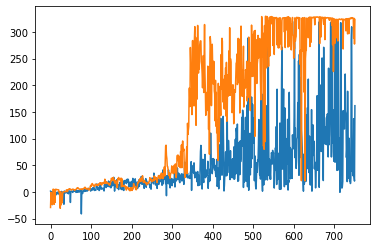

In [7]:
plt.plot(rewards_log)

In [4]:
#_model._actor.load_weights('ppo-1000.hdf5')

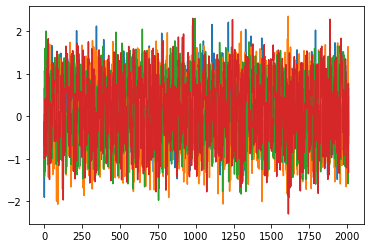

In [5]:
plt.plot(old_actions)

In [ ]:
plt.plot(_old_means)
plt.show()
plt.plot(_old_stds)

In [ ]:
plt.plot(rewards_log)
plt.savefig('bipedal-ppo.png')

In [ ]:
import os
os.mkdir('bipedal_ppo')

In [ ]:
seed=1
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['PYTHONHASHSEED']=str(seed)
import numpy as np
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense ,Input,concatenate ,Conv2D,Conv2DTranspose,\
MaxPooling2D,AveragePooling2D, LSTM ,Reshape, TimeDistributed,ReLU, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adagrad
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import warnings
import glob
import math
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from collections import deque
from tqdm import tqdm,trange
import gym
from copy import copy , deepcopy
tf.test.is_gpu_available()

n_act=4
n_state=24
TanH=tensorflow.keras.layers.Activation('tanh')
Sigmoid=tensorflow.keras.layers.Activation('sigmoid')

class Actor(Model):
  def __init__(self,n_act):
    super(Actor, self).__init__()
    self.d1 = Dense(512, activation='relu')
    self.d2 = Dense(256, activation='relu')
    self.mean = Dense(n_act)
    self.tanh  = TanH
    self.sigmoid  = Sigmoid
    self.std = Dense(n_act)

  def call(self, x):
    
    x = self.d1(x)
    x = self.d2(x)
    #x = self.d3(x)
    #x = self.d4(x)
    mean = self.mean(x)
    mean = self.tanh(mean)
    std = self.std(x)
    std = self.sigmoid(std)
    return mean,std+10e-10

def test_reward():
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state_input = K.expand_dims(state, 0)
        mean,std = _model._actor(state_input)
        act=np.random.normal(mean,std)[0]
        next_state, reward, done, _ = env.step(mean[0])
        if reward == -100:
            reward=-2
        state = next_state
        total_reward += reward
        
    return total_reward
_actor=Actor(n_act)
_actor(np.ones((1,24)))
_actor.load_weights('ppo_best_actor.hdf5')
env = gym.make('BipedalWalker-v2')
env.seed(seed)

In [ ]:
state=env.reset()
i=0
ter_count=0
while True:
    action=_actor(state.reshape(1,24))
    state,rwd,ter,info=env.step(action[0][0])
    img=env.render('rgb_array')
    cv2.imwrite('bipedal_ppo/'+str(i)+'.jpg',img)
    i+=1
    if ter==True:
            ter_count+=1
            state=env.reset()
    if ter_count==5:
             break

In [ ]:
env.close()

In [ ]:
import gym
env = gym.make('BipedalWalker-v2')
env.reset()
env.step([[1,1,1,1]])
#img=env.render('rgb_array')

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(img)